In [6]:
import os
import pandas as pd
import numpy as np
from numpy.random import RandomState

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import utils
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering


from pprint import pprint
from time import time
import logging

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import CategoricalNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier



# Define randomState constant to make the experiments replicable
seed = RandomState(0)
utils.check_random_state(seed)

# Read training set
features = ['title', 'concatenated_tags', 'query', 'search_page', 'price', 'weight', 'seller_id', 'minimum_quantity', 'category']
# products = pd.read_csv(os.environ['DATASET_PATH'], usecols=features)
products = pd.read_csv('e:/work/intelligent-systems-project/data/sample_products.csv', usecols=features)

# Clean products null and NaN occurrences. Remove only 60 lines from 38000 in total. 
products = products.dropna() # apaga apenas 60 linhas
products = products.reset_index()

# Read test set
# products_test = pd.read_csv('/usr/src/data/test_products.csv', usecols=features)
products_test = pd.read_csv('e:/work/intelligent-systems-project/data/test_products.csv', usecols=features)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")


# Common functions
def evaluate_test(predicted):
    target = products_test['category']
    categories = ['Lembrancinhas', 'Decoração', 'Bebê', 'Papel e Cia', 'Outros', 'Bijuterias e Jóias']
    accuracy = accuracy_score(target, predicted)
    f1_score_micro = f1_score(products_test['category'], predicted, average='micro', labels=categories)
    print(" test: %f (Accuracy: %f, F1_score(micro): %f)" % ( (accuracy+f1_score_micro)/2, accuracy, f1_score_micro) )

def concatCols(dataset, textColumnList): 
    SEP = " "
    INPUT_COLUMNS_WITH_SEP = ",sep,".join(textColumnList).split(",")
    return dataset.assign(sep=SEP)[INPUT_COLUMNS_WITH_SEP].sum(axis=1)
    
    

print("%d documents" % len(products))
print("%d categories" % len(products['category'].value_counts()))
print()

print('Setup complete!')



37940 documents
6 categories

Setup complete!


# 1. Initial training data verification
- verify loaded columns data types OK
- verify presence of nulls and NaN OK
- verify target categories, is it balanced? Not, it is not balanced.
```
Lembrancinhas         17524
Decoração              8723
Bebê                   6930
Papel e Cia            2750
Outros                 1133
Bijuterias e Jóias      940
```

# 2. Setting an experiment baseline 

GridSearchCV class provides a cross-validation method to search for hyperparameters. It will be used as base for next exploration. The experiment baseline uses a **5-fold cross-validation**, **no hyperparameters** exploration and **accuracy** and **f1_score** metrics.

### Pipeline
Utilizes a **CountVectorizer** feature extraction steio (bag-of-words) in **'title' column**. Passing data to a **SGDClassifier**.
Based on [Sample pipeline for text feature extraction and evaluation](https://scikit-learn.org/0.15/auto_examples/grid_search_text_feature_extraction.html)

### Scores: 
```
pipeline: ['vect', 'clf']
Fitting 5 folds for each of 1 candidates, totalling 5 fits
done in 2.861s

train: 0.907940 (mean of Accuracy and F1_score(micro))
  val: 0.874750 (mean of Accuracy and F1_score(micro))
 test: 0.896000 (Accuracy: 0.896000, F1_score(micro): 0.896000)
```

In [2]:
def exp1(textColumnsList):
    X_train = concatCols(products, textColumnsList)
    X_test = concatCols(products_test, textColumnsList)
    Y_train = products['category']

    scoring = {'Accuracy': 'accuracy', 'F1_score': 'f1_micro' }
    
    pipeline = Pipeline(
        [
            ("vect", CountVectorizer()),
            ("clf", SGDClassifier(random_state=0)),
        ]
    )
    
    parameters = {}

    if __name__ == "__main__":
        # multiprocessing requires the fork to happen in a __main__ protected block
        # find the best parameters for both the feature extraction and the classifier
        grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=4, scoring=scoring, refit="Accuracy", return_train_score=True)

        print("pipeline:", [name for name, _ in pipeline.steps])

        t0 = time()
        grid_search.fit(X_train, Y_train)
        print("done in %0.3fs" % (time() - t0))
        print()

        print("train: %f (mean of Accuracy and F1_score(micro))"  % grid_search.cv_results_['mean_train_Accuracy']) # mean of Accuracy and F1_score(micro)
        print("  val: %f (mean of Accuracy and F1_score(micro))"  % grid_search.cv_results_['mean_test_Accuracy']) # mean of Accuracy and F1_score(micro)

        predicted = grid_search.best_estimator_.predict(X_test)
        evaluate_test(predicted)

    
exp1(['title'])   



pipeline: ['vect', 'clf']
Fitting 5 folds for each of 1 candidates, totalling 5 fits
done in 4.036s

train: 0.907940 (mean of Accuracy and F1_score(micro))
  val: 0.874750 (mean of Accuracy and F1_score(micro))
 test: 0.896000 (Accuracy: 0.896000, F1_score(micro): 0.896000)


# 3. Getting a feeling about the other text columns

May be there is a better text column than 'title' to use.
May be I could combine all of them.
The objetive of this experiement is to get a feeling if the others text columns could be useful. 

### Results:
Using a combination of columns **title**, **concatenated_tags** and **query** seems to contribute to improve results.
```
<| ['title', 'concatenated_tags', 'query'] |>
pipeline: ['vect', 'clf']
Fitting 5 folds for each of 1 candidates, totalling 5 fits
done in 5.334s

train: 0.937078 (mean of Accuracy and F1_score(micro))
  val: 0.896310 (mean of Accuracy and F1_score(micro))
 test: 0.930000 (Accuracy: 0.930000, F1_score(micro): 0.930000)


Crossvalidation: from 0.874750 to 0.896310.
Test: from 0.896000 to 0.930000.
Test accuracy: from 0.896000 to 0.930000.
Test F1_score(micro): from 0.896000 to 0.930000
```



In [3]:
combinationsToTest = [
    ['title'],
    ['concatenated_tags'],
    ['query'],
    ['title', 'concatenated_tags'],
    ['title', 'query'],
    ['concatenated_tags', 'query'],
    ['title', 'concatenated_tags', 'query']
]

for k in combinationsToTest:
    print('<|',k,'|>')
    exp1(k)
    print('-----------------------------------------------------------------\n')



<| ['title'] |>
pipeline: ['vect', 'clf']
Fitting 5 folds for each of 1 candidates, totalling 5 fits
done in 2.929s

train: 0.907940 (mean of Accuracy and F1_score(micro))
  val: 0.874750 (mean of Accuracy and F1_score(micro))
 test: 0.896000 (Accuracy: 0.896000, F1_score(micro): 0.896000)
-----------------------------------------------------------------

<| ['concatenated_tags'] |>
pipeline: ['vect', 'clf']
Fitting 5 folds for each of 1 candidates, totalling 5 fits
done in 3.063s

train: 0.888897 (mean of Accuracy and F1_score(micro))
  val: 0.854929 (mean of Accuracy and F1_score(micro))
 test: 0.860000 (Accuracy: 0.860000, F1_score(micro): 0.860000)
-----------------------------------------------------------------

<| ['query'] |>
pipeline: ['vect', 'clf']
Fitting 5 folds for each of 1 candidates, totalling 5 fits
done in 2.303s

train: 0.857716 (mean of Accuracy and F1_score(micro))
  val: 0.839352 (mean of Accuracy and F1_score(micro))
 test: 0.858000 (Accuracy: 0.858000, F1_score

# 4. Exploring some parameters for CountVectorizer

I think the combined text column from previous experiment (title, tags, query) problably will result in some duplicated words. I order to avoid misinterpreting duplicate words as more valuable words I will try adding parameter binary: True . When enabled, if True, all non zero counts are set to 1. When enabling it, I expect getting the same score in baseline and better score when using combined text column.

I will use this experiment to explore other configurations of this module. Some parameters ideas came from [Sample pipeline for text feature extraction and evaluation](https://scikit-learn.org/0.15/auto_examples/grid_search_text_feature_extraction.html).

```
strip_accents{None, ‘unicode’}
stop_words{None, stop_portugues, stop_portugues_small }
binary{False, True}
max_features
max_df: (0.5, 0.75, 1.0),
max_features: (None, 5000, 10000, 50000),
ngram_range: ((1, 1), (1, 2)),  # unigrams or bigrams
```

### Results:
The varatiation is small, but it seems that we should use binary: True

```
Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'vect__binary': (False, True),
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__max_features': (None, 5000, 10000, 50000),
 'vect__ngram_range': ((...), (...)),
 'vect__stop_words': (None, [...], [...], [...]),
 'vect__strip_accents': (None, 'unicode')}
Fitting 5 folds for each of 384 candidates, totalling 1920 fits
done in 2147.774s

Best parameters set:
	vect__binary: True
	vect__max_df: 0.5
	vect__max_features: None
	vect__ngram_range: (1, 2)
	vect__stop_words: ['de', 'do', 'dos', 'com', 'em', 'o', 'e', 'para', 'em']
	vect__strip_accents: None
  val: 0.924776 (mean of Accuracy and F1_score(micro))
 test: 0.956000 (Accuracy: 0.956000, F1_score(micro): 0.956000)
 
 
 train: 0.937078 (mean of Accuracy and F1_score(micro))
  val: 0.896310 (mean of Accuracy and F1_score(micro))
 test: 0.930000 (Accuracy: 0.930000, F1_score(micro): 0.930000)
 
Crossvalidation: from 0.896310 to 0.924776.
Test: from 0.930000 to 0.956000.
Test accuracy: from 0.930000 to 0.956000.
Test F1_score(micro):  0.930000 to 0.956000
 ```



In [5]:
def exp2(textColumnsList):
    X_train = concatCols(products, textColumnsList)
    X_test = concatCols(products_test, textColumnsList)
    Y_train = products['category']

    scoring = {'Accuracy': 'accuracy', 'F1_score': 'f1_micro' }
    
    pipeline = Pipeline(
        [
            ("vect", CountVectorizer()),
            ("clf", SGDClassifier(random_state=0)),
        ]
    )
    
    stop_portugues_fromInternet = ['de', 'a', 'o', 'que', 'e', 'do', 'da', 'em', 'um', 'para', 'e', 'com', 'nao', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'foi', 'ao', 'ele', 'das', 'tem', 'a', 'seu', 'sua', 'ou', 'ser', 'quando', 'muito', 'ha', 'nos', 'ja', 'esta', 'eu', 'tambem', 'so', 'pelo', 'pela', 'ate', 'isso', 'ela', 'entre', 'era', 'depois', 'sem', 'mesmo', 'aos', 'ter', 'seus', 'quem', 'nas', 'me', 'esse', 'eles', 'estao', 'voce', 'tinha', 'foram', 'essa', 'num', 'nem', 'suas', 'meu', 'as', 'minha', 'tem', 'numa', 'pelos', 'elas', 'havia', 'seja', 'qual', 'sera', 'nos', 'tenho', 'lhe', 'deles', 'essas', 'esses', 'pelas', 'este', 'fosse', 'dele', 'tu', 'te', 'voces', 'vos', 'lhes', 'meus', 'minhas', 'teu', 'tua', 'teus', 'tuas', 'nosso', 'nossa', 'nossos', 'nossas', 'dela', 'delas', 'esta', 'estes', 'estas', 'aquele', 'aquela', 'aqueles', 'aquelas', 'isto', 'aquilo', 'estou', 'esta', 'estamos', 'estao', 'estive', 'esteve', 'estivemos', 'estiveram', 'estava', 'estavamos', 'estavam', 'estivera', 'estiveramos', 'esteja', 'estejamos', 'estejam', 'estivesse', 'estivessemos', 'estivessem', 'estiver', 'estivermos', 'estiverem', 'hei', 'ha', 'havemos', 'hao', 'houve', 'houvemos', 'houveram', 'houvera', 'houveramos', 'haja', 'hajamos', 'hajam', 'houvesse', 'houvessemos', 'houvessem', 'houver', 'houvermos', 'houverem', 'houverei', 'houvera', 'houveremos', 'houverao', 'houveria', 'houveriamos', 'houveriam', 'sou', 'somos', 'sao', 'era', 'eramos', 'eram', 'fui', 'foi', 'fomos', 'foram', 'fora', 'foramos', 'seja', 'sejamos', 'sejam', 'fosse', 'fossemos', 'fossem', 'for', 'formos', 'forem', 'serei', 'sera', 'seremos', 'serao', 'seria', 'seriamos', 'seriam', 'tenho', 'tem', 'temos', 'tem', 'tinha', 'tinhamos', 'tinham', 'tive', 'teve', 'tivemos', 'tiveram', 'tivera', 'tiveramos', 'tenha', 'tenhamos', 'tenham', 'tivesse', 'tivessemos', 'tivessem', 'tiver', 'tivermos', 'tiverem', 'terei', 'tera', 'teremos', 'terao', 'teria', 'teriamos', 'teriam']
    stop_portguese_fromElo7 = ['cod', 'mod', 'de', 'a', 'o', 'que', 'e', 'do', 'da', 'em', 'um', 'para', 'com', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'ao', 'ele', 'das', 'a', 'seu', 'sua', 'ou', 'quando', 'muito', 'nos', 'ja', 'eu', 'tambem', 'so', 'pelo', 'pela', 'ate', 'isso', 'ela', 'entre', 'depois', 'sem', 'mesmo', 'aos', 'seus', 'quem', 'nas', 'me', 'esse', 'eles', 'voce', 'essa', 'num', 'suas', 'meu', 'as', 'minha', 'numa', 'pelos', 'elas', 'qual', 'nos', 'lhe', 'deles', 'essas', 'esses', 'pelas', 'este', 'dele', 'tu', 'vos', 'lhes', 'meus', 'minhas', 'teu', 'tua', 'teus', 'tuas', 'nosso', 'nossa', 'nossos', 'nossas', 'dela', 'delas', 'esta', 'estes', 'estas', 'aquele', 'aquela', 'aqueles', 'aquelas', 'isto', 'aquilo', 'estou', 'esta', 'estamos', 'estao', 'estive', 'esteve', 'estivemos', 'estiveram', 'estava', 'estavamos', 'estavam', 'estivera', 'estiveramos', 'esteja', 'estejamos', 'estejam', 'estivesse', 'estivessemos', 'estivessem', 'estiver', 'estivermos', 'estiverem', 'hei', 'ha', 'havemos', 'hao', 'houve', 'houvemos', 'houveram', 'houvera', 'houveramos', 'haja', 'hajamos', 'hajam', 'houvesse', 'houvessemos', 'houvessem', 'houver', 'houvermos', 'houverem', 'houverei', 'houvera', 'houveremos', 'houverao', 'houveria', 'houveriamos', 'houveriam', 'sou', 'somos', 'sao', 'era', 'eramos', 'eram', 'fui', 'foi', 'fomos', 'foram', 'fora', 'foramos', 'seja', 'sejamos', 'sejam', 'fosse', 'fossemos', 'fossem', 'for', 'formos', 'forem', 'serei', 'sera', 'seremos', 'serao', 'seria', 'seriamos', 'seriam', 'tenho', 'tem', 'temos', 'tem', 'tinha', 'tinhamos', 'tinham', 'tive', 'teve', 'tivemos', 'tiveram', 'tivera', 'tiveramos', 'tenha', 'tenhamos', 'tenham', 'tivesse', 'tivessemos', 'tivessem', 'tiver', 'tivermos', 'tiverem', 'terei', 'tera', 'teremos', 'terao', 'teria', 'teriamos', 'teriam', 'te', 'voces']
    stop_portuquese_fromWordclouds = ['de', 'do', 'dos', 'com', 'em', 'o', 'e', 'para', 'em']
    parameters = {
        'vect__max_df': (0.5, 0.75, 1.0),
        'vect__max_features': (None, 5000, 10000, 50000),
        'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
        'vect__strip_accents': (None, 'unicode'),
        'vect__binary': (False, True),
        'vect__stop_words': (None, stop_portugues_fromInternet, stop_portguese_fromElo7, stop_portuquese_fromWordclouds),
    }
    
    if __name__ == "__main__":
        # multiprocessing requires the fork to happen in a __main__ protected block
        # find the best parameters for both the feature extraction and the classifier
        grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring=scoring, refit="Accuracy", return_train_score=True)

        print("Performing grid search...")
        print("pipeline:", [name for name, _ in pipeline.steps])
        print("parameters:")
        pprint(parameters, depth=2, compact=True)
        t0 = time()
        grid_search.fit(X_train, Y_train)
        print("done in %0.3fs" % (time() - t0))
        print()

        print("Best parameters set:")
        best_parameters = grid_search.best_estimator_.get_params()
        for param_name in sorted(parameters.keys()):
            print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
        print("  val: %f (mean of Accuracy and F1_score(micro))" % grid_search.best_score_)

        predicted = grid_search.best_estimator_.predict(X_test)
        evaluate_test(predicted)
        
        


exp2(['title', 'concatenated_tags', 'query'])

          

Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'vect__binary': (False, True),
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__max_features': (None, 5000, 10000, 50000),
 'vect__ngram_range': ((...), (...)),
 'vect__stop_words': (None, [...], [...], [...]),
 'vect__strip_accents': (None, 'unicode')}
Fitting 5 folds for each of 384 candidates, totalling 1920 fits
done in 2147.774s

Best parameters set:
	vect__binary: True
	vect__max_df: 0.5
	vect__max_features: None
	vect__ngram_range: (1, 2)
	vect__stop_words: ['de', 'do', 'dos', 'com', 'em', 'o', 'e', 'para', 'em']
	vect__strip_accents: None
  val: 0.924776 (mean of Accuracy and F1_score(micro))
 test: 0.956000 (Accuracy: 0.956000, F1_score(micro): 0.956000)


# 5. Exploring word clouds

I would like to take look in text columns.
May be it can give me a hint for a better [stop_word](https://en.wikipedia.org/wiki/Stop_word) list.

### Results:
Title and query columns we could see clearly some stop_words: de, do, dos, com, em, o, e, para, em
On the other hand, in **concatenated_tags** I cannot see any stop_words.

```
stop_portuquese_fromWordclouds = ['de', 'do', 'dos', 'com', 'em', 'o', 'e', 'para', 'em']
```

After comming back to previous experiment to test the found stop_word list, this simpler stop_words was selected.


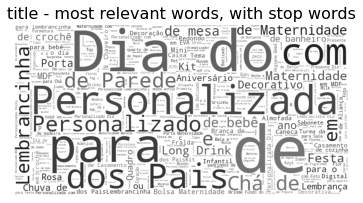

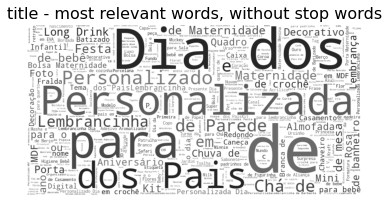

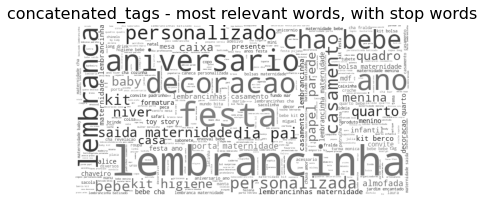

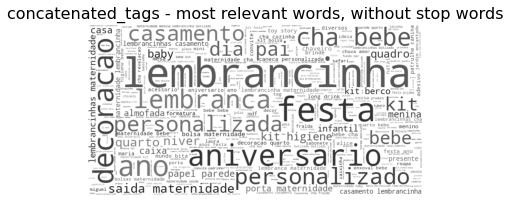

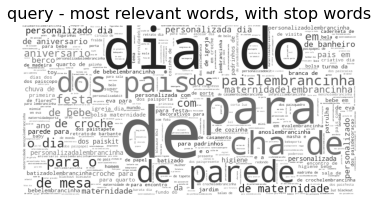

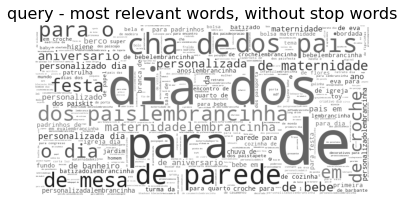

In [6]:
import random
from wordcloud import WordCloud, ImageColorGenerator

def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(10, 50)

def generate_cloud(wordcloud, lines, title):
    wordcloud.generate(''.join(lines))
    wordcloud.recolor(color_func=grey_color_func)

    plt.title(title, fontdict={'fontsize': 16})
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()


# Raw word cloud (with stop words)
raw_wordcloud = WordCloud(random_state=42, width=720, height=368, max_words=8000, background_color='white', stopwords='')

# Cleant word cloud (without stop words)
clean_wordcloud = WordCloud(random_state=42, width=720, height=368, max_words=8000, background_color='white')

# All documents (with/without stop words)
data = products['title'].tolist()
generate_cloud(raw_wordcloud, data, "title - most relevant words, with stop words")
generate_cloud(clean_wordcloud, data, "title - most relevant words, without stop words")

data = products['concatenated_tags'].tolist()
generate_cloud(raw_wordcloud, data, "concatenated_tags - most relevant words, with stop words")
generate_cloud(clean_wordcloud, data, "concatenated_tags - most relevant words, without stop words")

data = products['query'].tolist()
generate_cloud(raw_wordcloud, data, "query - most relevant words, with stop words")
generate_cloud(clean_wordcloud, data, "query - most relevant words, without stop words")




# 6. Trying a term-frenquency to improve feature extraction

The sample [pipeline](https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html) that I am using metions a TfidfTransformer.
Tf means term-frequency while tf-idf means term-frequency times inverse document-frequency. 
Even not thinking that word relative frequency can improve the results, as it do not need much time, I think it worth testing.

### Results: 
Adding TfidfTransformer() did not improve the pipeline.

In [8]:
def exp3(textColumnsList):
    X_train = concatCols(products, textColumnsList)
    X_test = concatCols(products_test, textColumnsList)
    Y_train = products['category']

    scoring = {'Accuracy': 'accuracy', 'F1_score': 'f1_micro' }

    stop_portugues_fromInternet = ['de', 'a', 'o', 'que', 'e', 'do', 'da', 'em', 'um', 'para', 'e', 'com', 'nao', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'foi', 'ao', 'ele', 'das', 'tem', 'a', 'seu', 'sua', 'ou', 'ser', 'quando', 'muito', 'ha', 'nos', 'ja', 'esta', 'eu', 'tambem', 'so', 'pelo', 'pela', 'ate', 'isso', 'ela', 'entre', 'era', 'depois', 'sem', 'mesmo', 'aos', 'ter', 'seus', 'quem', 'nas', 'me', 'esse', 'eles', 'estao', 'voce', 'tinha', 'foram', 'essa', 'num', 'nem', 'suas', 'meu', 'as', 'minha', 'tem', 'numa', 'pelos', 'elas', 'havia', 'seja', 'qual', 'sera', 'nos', 'tenho', 'lhe', 'deles', 'essas', 'esses', 'pelas', 'este', 'fosse', 'dele', 'tu', 'te', 'voces', 'vos', 'lhes', 'meus', 'minhas', 'teu', 'tua', 'teus', 'tuas', 'nosso', 'nossa', 'nossos', 'nossas', 'dela', 'delas', 'esta', 'estes', 'estas', 'aquele', 'aquela', 'aqueles', 'aquelas', 'isto', 'aquilo', 'estou', 'esta', 'estamos', 'estao', 'estive', 'esteve', 'estivemos', 'estiveram', 'estava', 'estavamos', 'estavam', 'estivera', 'estiveramos', 'esteja', 'estejamos', 'estejam', 'estivesse', 'estivessemos', 'estivessem', 'estiver', 'estivermos', 'estiverem', 'hei', 'ha', 'havemos', 'hao', 'houve', 'houvemos', 'houveram', 'houvera', 'houveramos', 'haja', 'hajamos', 'hajam', 'houvesse', 'houvessemos', 'houvessem', 'houver', 'houvermos', 'houverem', 'houverei', 'houvera', 'houveremos', 'houverao', 'houveria', 'houveriamos', 'houveriam', 'sou', 'somos', 'sao', 'era', 'eramos', 'eram', 'fui', 'foi', 'fomos', 'foram', 'fora', 'foramos', 'seja', 'sejamos', 'sejam', 'fosse', 'fossemos', 'fossem', 'for', 'formos', 'forem', 'serei', 'sera', 'seremos', 'serao', 'seria', 'seriamos', 'seriam', 'tenho', 'tem', 'temos', 'tem', 'tinha', 'tinhamos', 'tinham', 'tive', 'teve', 'tivemos', 'tiveram', 'tivera', 'tiveramos', 'tenha', 'tenhamos', 'tenham', 'tivesse', 'tivessemos', 'tivessem', 'tiver', 'tivermos', 'tiverem', 'terei', 'tera', 'teremos', 'terao', 'teria', 'teriamos', 'teriam']
    
    pipeline = Pipeline(
        [
            ("vect", CountVectorizer(binary=True, max_df=0.5, max_features=None, ngram_range=(1, 2), strip_accents=None, stop_words=stop_portugues_fromInternet )),
            ('tfidf', TfidfTransformer()),
            ("clf", SGDClassifier(random_state=0)),
        ]
    )
    
    parameters = {
        'tfidf__use_idf': (True, False),
        'tfidf__norm': ('l1', 'l2'),
    }
    
    if __name__ == "__main__":
        # multiprocessing requires the fork to happen in a __main__ protected block
        # find the best parameters for both the feature extraction and the classifier
        grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring=scoring, refit="Accuracy", return_train_score=True)

        print("Performing grid search...")
        print("pipeline:", [name for name, _ in pipeline.steps])
        print("parameters:")
        pprint(parameters, depth=2, compact=True)
        t0 = time()
        grid_search.fit(X_train, Y_train)
        print("done in %0.3fs" % (time() - t0))
        print()

        print("Best parameters set:")
        best_parameters = grid_search.best_estimator_.get_params()
        for param_name in sorted(parameters.keys()):
            print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
        print("  val: %f (mean of Accuracy and F1_score(micro))" % grid_search.best_score_)

        predicted = grid_search.best_estimator_.predict(X_test)
        evaluate_test(predicted)
        
        


exp3(['title', 'concatenated_tags', 'query'])

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'tfidf__norm': ('l1', 'l2'), 'tfidf__use_idf': (True, False)}
Fitting 5 folds for each of 4 candidates, totalling 20 fits
done in 21.568s

Best parameters set:
	tfidf__norm: 'l2'
	tfidf__use_idf: True
  val: 0.903189 (mean of Accuracy and F1_score(micro))
 test: 0.928000 (Accuracy: 0.928000, F1_score(micro): 0.928000)


# 7. Another strategy for using 'query' column

The **query** column is a open field that brings text inserted by users to find the product. 
There is a auxiliary columns called **search_page** that represents the page number where the product appeared.
I wondering if queries that find the product in first pages are better to feed the classifier.
This experiment will filter training dataset by search_page and follow any impact in performance.

### Results
I tried two strategies.
1. Add rows only if search_page <= limit. Throw out some rows.      
2. Use all rows, but combine in text columns only if search_page <= limit

The results do not show any clear improvement.


In [3]:
def exp4(textColumnsList, products, products_test):
    X_train = concatCols(products, textColumnsList)
    X_test = concatCols(products_test, textColumnsList)
    Y_train = products['category']

    scoring = {'Accuracy': 'accuracy', 'F1_score': 'f1_micro' }

    stop_portuquese_fromWordclouds = ['de', 'do', 'dos', 'com', 'em', 'o', 'e', 'para', 'em']
    
    pipeline = Pipeline(
        [
            ("vect", CountVectorizer(binary=True, max_df=0.5, max_features=None, ngram_range=(1, 2), strip_accents=None, stop_words=stop_portuquese_fromWordclouds )),
            ("clf", SGDClassifier(random_state=0)),
        ]
    )
    
    parameters = {
    }
    
    if __name__ == "__main__":
        # multiprocessing requires the fork to happen in a __main__ protected block
        # find the best parameters for both the feature extraction and the classifier
        grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring=scoring, refit="Accuracy", return_train_score=True)

        print("Performing grid search...")
        print("pipeline:", [name for name, _ in pipeline.steps])
        print("parameters:")
        pprint(parameters, depth=2, compact=True)
        t0 = time()
        grid_search.fit(X_train, Y_train)
        print("done in %0.3fs" % (time() - t0))
        print()

        print("Best parameters set:")
        best_parameters = grid_search.best_estimator_.get_params()
        for param_name in sorted(parameters.keys()):
            print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
        print("  val: %f (mean of Accuracy and F1_score(micro))" % grid_search.best_score_)

        predicted = grid_search.best_estimator_.predict(X_test)
        evaluate_test(predicted)
        

# 1. Add rows only if search_page <= limit. Throw out some rows.      
# search_pageLimitToEvaluate = range(1,6)
# for limit in search_pageLimitToEvaluate:
#     print(limit)
#     products_train_exp4 = products[products['search_page'] <= limit]
#     products_test_exp4 = products_test
#     print('search_page <=', str(limit))
#     exp4(['title', 'concatenated_tags', 'query'], products_train_exp4, products_test_exp4)

# 2. Use all rows, but combine in text columns only if search_page <= limit
# def create_custom_text_exp4 (row, limit):
#     if(row['search_page'] <= limit):
#         return row['title'] + ' ' + row['concatenated_tags'] + ' ' + row['query']
#     else:
#         return row['title'] + ' ' + row['concatenated_tags']

# search_pageLimitToEvaluate = range(1,6)
# for limit in search_pageLimitToEvaluate:
#     print(limit)
#     products_train_exp4 = products
#     products_test_exp4 = products_test
    
#     products_train_exp4['text'] = products_train_exp4.apply (lambda row: create_custom_text_exp4(row, limit), axis=1) 
#     products_test_exp4['text'] = products_test_exp4.apply (lambda row: create_custom_text_exp4(row, limit), axis=1) 
    
#     exp4(['text'], products_train_exp4, products_test_exp4)

[CV 1/5] END  Accuracy: (train=0.908, test=0.881) F1_score: (train=0.908, test=0.881) total time=   0.8s
[CV 4/5] END  Accuracy: (train=0.907, test=0.872) F1_score: (train=0.907, test=0.872) total time=   0.8s
[CV 2/5] END  Accuracy: (train=0.908, test=0.872) F1_score: (train=0.908, test=0.872) total time=   0.8s
[CV 3/5] END  Accuracy: (train=0.910, test=0.867) F1_score: (train=0.910, test=0.867) total time=   0.7s
[CV 5/5] END  Accuracy: (train=0.907, test=0.882) F1_score: (train=0.907, test=0.882) total time=   0.5s


# 8. Balancing dataset

The dataset is clearly unbalanced. Even the current F1_score being high (0.956). May be it is possible to improve the classifier performance.

On the other hand, the test set appears to have the same unbalanced distribution of categories. Perhaps the teacher did this to make the work easier.


### Results:
- 1. Random-under sampling degraded overall performance. Seems to be an under-fitting. Score crossvaldation and test are small.
- 2. Random over-sampling. Seems to be an over-fitting. Score crossvaldation >> Score test.
- 3. Random under-sampling of 'Lembrancinhas' to 'Decoracao' count. Random over-sampling others categories to 'Decoracao' count. Seems to be an over-fitting. Score crossvaldation >> Score test.

No improvement in overall performance.

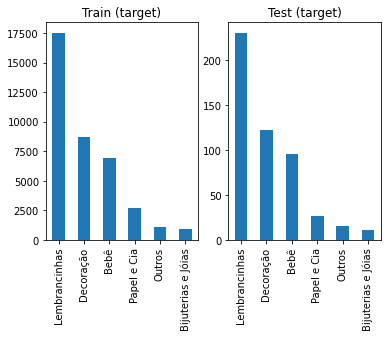

In [54]:
# Curent train and test distribuition
plt.subplot(1, 2, 1)
products['category'].value_counts().plot(kind='bar', title='Train (target)');
plt.subplot(1, 2, 2)
products_test['category'].value_counts().plot(kind='bar', title='Test (target)');

# 1. Random under-sampling
Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
done in 1.420s

Best parameters set:
  val: 0.857979 (mean of Accuracy and F1_score(micro))
 test: 0.874000 (Accuracy: 0.874000, F1_score(micro): 0.874000)
# 2. Random over-sampling
Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
done in 23.998s

Best parameters set:
  val: 0.979746 (mean of Accuracy and F1_score(micro))
 test: 0.930000 (Accuracy: 0.930000, F1_score(micro): 0.930000)
'# 3. Random under-sampling of 'Lembrancinhas' to 'Decoracao' count. andom over-sampling other other categories to 'Decoracao' count.
Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
done in 12.093s

Best parameters set:
  val: 0.964153 (mean of Accuracy and F1_score(micro))
 test: 0.934000 (Accuracy: 0.

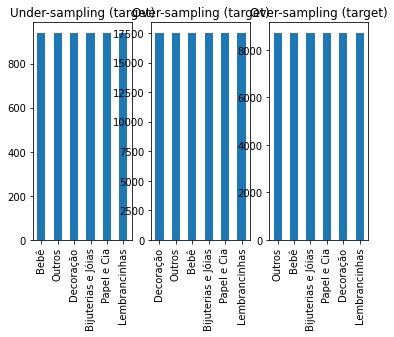

In [58]:
# Class count
count_class_lembrancinhas, count_class_decoracao, count_class_bebe, count_class_papelecia, count_class_outros, count_class_bijuterias = products['category'].value_counts()

# Divide by class
df_class_lembrancinhas = products[products['category'] == 'Lembrancinhas']
df_class_decoracao = products[products['category'] == 'Decoração']
df_class_bebe = products[products['category'] == 'Bebê']
df_class_papelecia = products[products['category'] == 'Papel e Cia']
df_class_outros = products[products['category'] == 'Outros']
df_class_bijuterias = products[products['category'] == 'Bijuterias e Jóias']

# 1. Random under-sampling
df_class_lembrancinhas_under = df_class_lembrancinhas.sample(count_class_bijuterias)
df_class_decoracao_under = df_class_decoracao.sample(count_class_bijuterias)
df_class_bebe_under = df_class_bebe.sample(count_class_bijuterias)
df_class_papelecia_under = df_class_papelecia.sample(count_class_bijuterias)
df_class_outros_under = df_class_outros.sample(count_class_bijuterias)
products_train_under = pd.concat([df_class_lembrancinhas_under, df_class_decoracao_under, df_class_bebe_under, df_class_papelecia_under, df_class_outros_under, df_class_bijuterias], axis=0)

# sns.displot(products_under, x="category").set(title='Random under-sampling')
plt.subplot(1, 3, 1)
products_train_under['category'].value_counts().plot(kind='bar', title='Under-sampling (target)');

# Running experiment
print('# 1. Random under-sampling')
exp4(['title', 'concatenated_tags', 'query'], products_train_under, products_test)


# 2. Random over-sampling
df_class_decoracao_over = df_class_decoracao.sample(count_class_lembrancinhas, replace=True)
df_class_bebe_over = df_class_bebe.sample(count_class_lembrancinhas, replace=True)
df_class_papelecia_over = df_class_papelecia.sample(count_class_lembrancinhas, replace=True)
df_class_outros_over = df_class_outros.sample(count_class_lembrancinhas, replace=True)
df_class_bijuterias_over = df_class_bijuterias.sample(count_class_lembrancinhas, replace=True)

products_train_over = pd.concat([df_class_lembrancinhas, df_class_decoracao_over, df_class_bebe_over, df_class_papelecia_over, df_class_outros_over, df_class_bijuterias_over], axis=0)
products_train_over.reset_index()

plt.subplot(1, 3, 2)
products_train_over['category'].value_counts().plot(kind='bar', title='Over-sampling (target)');
print('# 2. Random over-sampling')
exp4(['title', 'concatenated_tags', 'query'], products_train_over, products_test)


# 3. Random under-sampling of 'Lembrancinhas' to 'Decoracao' count. andom over-sampling other other categories to 'Decoracao' count.
df_class_lembrancinhas_under = df_class_lembrancinhas.sample(count_class_decoracao)
df_class_bebe_over = df_class_bebe.sample(count_class_decoracao, replace=True)
df_class_papelecia_over = df_class_papelecia.sample(count_class_decoracao, replace=True)
df_class_outros_over = df_class_outros.sample(count_class_decoracao, replace=True)
df_class_bijuterias_over = df_class_bijuterias.sample(count_class_decoracao, replace=True)
products_train_under_over = pd.concat([df_class_lembrancinhas_under, df_class_decoracao, df_class_bebe_over, df_class_papelecia_over, df_class_outros_over, df_class_bijuterias_over], axis=0)
products_train_under_over.reset_index()

plt.subplot(1, 3, 3)
products_train_under_over['category'].value_counts().plot(kind='bar', title='Over-sampling (target)');

print("'# 3. Random under-sampling of 'Lembrancinhas' to 'Decoracao' count. andom over-sampling other other categories to 'Decoracao' count.")
exp4(['title', 'concatenated_tags', 'query'], products_train_under_over, products_test)



# 9. Trying to creating text features from numeric columns (manual intervals)

The price, weight and minimum quantity columns seem to provide useful information. As the classifier is receiving the bag-of-words directly, I'm not sure how to integrate them into the model.

I will try to create text columns with distinct words to mark ranges of values from these columns.
For example: priceLow, priceMedium and priceHigh to indicate value ranges for the price column.

Tried setting ranges manually based on the average values for each of the output categories.

### Results:
```
  val: 0.926990 (mean of Accuracy and F1_score(micro))
 test: 0.952000 (Accuracy: 0.952000, F1_score(micro): 0.952000)
 
 crossvalidation: from 0.924776 to 0.926990.
 test: from 0.956000 to 0.952000 (small degradation)
test accuracy: from 0.956000 to 0.952000 (degradation)
test F1_score(micro): (0.956000) to 0.952000 (degradation)
 ```
**No improvement.**


In [59]:
#1. Creating features.
def label_price (row):
    if row['price'] <= 30:
        return 'priceLow'
    elif row['price'] > 30 and row['price'] < 100:
        return 'priceMedium'
    else:
        return 'priceHigh'

def label_weight (row):
    if row['weight'] <= 100:
        return 'weightLow'
    elif row['weight'] > 100 and row['weight'] < 300:
        return 'weightMedium'
    else:
        return 'weightHigh'    

def label_min_qt (row):
    if row['minimum_quantity'] <= 4:
        return 'mqLow'
    elif row['minimum_quantity'] > 4 and row['minimum_quantity'] <= 16:
        return 'mqMedium'
    else:
        return 'mqHigh'    

products_train_exp5 = products
products_test_exp5 = products_test

products_train_exp5['priceInterval'] = products_train_exp5.apply (lambda row: label_price(row), axis=1) 
products_train_exp5['weightInterval'] = products_train_exp5.apply (lambda row: label_weight(row), axis=1) 
products_train_exp5['mqInterval'] = products_train_exp5.apply (lambda row: label_min_qt(row), axis=1) 

products_test_exp5['priceInterval'] = products_test_exp5.apply (lambda row: label_price(row), axis=1) 
products_test_exp5['weightInterval'] = products_test_exp5.apply (lambda row: label_weight(row), axis=1) 
products_test_exp5['mqInterval'] = products_test_exp5.apply (lambda row: label_min_qt(row), axis=1) 


exp4(['title', 'concatenated_tags', 'query', 'priceInterval', 'weightInterval', 'mqInterval'], products_train_exp5, products_test_exp5)




Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
done in 11.432s

Best parameters set:
  val: 0.926990 (mean of Accuracy and F1_score(micro))
 test: 0.952000 (Accuracy: 0.952000, F1_score(micro): 0.952000)


# 10. Trying to creating text features from numeric columns (automatic intervals)

I didn't see an improvement in the previous experiment. Maybe it's because I didn't choose good intervals. I will try to define groups from these numeric columns using the k-means algorithm.

### Results:
For **n-cluster = 23** we have got a good improvement.
```
    val: 0.926542 (mean of Accuracy and F1_score(micro))
 test: 0.962000 (Accuracy: 0.962000, F1_score(micro): 0.962000)
 
 
 crossvalidation: from 0.924776 to 0.926542.
 test: from 0.956000 to 0.962000 
test accuracy: from 0.956000 to 0.962000 
test F1_score(micro): from 0.956000 to 0.962000
```




In [8]:
#2. Using a clustering algorhitm to define betters labels

def create_feature_kmeansPriceWeightMinimumQuantity(products_train, products_test, ncluster):
    kMeansPipeline = Pipeline(
        [
            ("scaler", StandardScaler()),
            ("kmeans", KMeans(n_clusters=ncluster, random_state=0)),

        ]
    )

    kmeansArray_train = kMeansPipeline.fit_predict(products_train[['price', 'weight', 'minimum_quantity']].dropna())
    kmeansArray_test  = kMeansPipeline.predict(products_test[['price', 'weight', 'minimum_quantity']])

    kmeansSeries_train = pd.Series(kmeansArray_train, name="kmeans")
    kmeansSeries_test = pd.Series(kmeansArray_test, name="kmeans")

    products_train_exp6 = pd.concat([products_train, kmeansSeries_train], axis=1)
    products_train_exp6['kmeansPriceWeightMinimumQuantity'] = 'grupo' + products_train_exp6['kmeans'].astype(str)

    products_test_exp6 = pd.concat([products_test, kmeansSeries_test], axis=1)
    products_test_exp6['kmeansPriceWeightMinimumQuantity'] = 'grupo' + products_test_exp6['kmeans'].astype(str)
    
    return(products_train_exp6, products_test_exp6)
    
def exp6(nclusterList, products_train, products_test): 
    for ncluster in nclusterList:
        print(ncluster)
    
        products_train_exp6, products_test_exp6 = create_feature_kmeansPriceWeightMinimumQuantity(products_train, products_test, ncluster)
    
        print('<| n-cluster:', ncluster, '|>')
        exp4(['title', 'concatenated_tags', 'query', 'kmeansPriceWeightMinimumQuantity'], products_train_exp6, products_test_exp6) 


# exp6(range(3, 50, 1), products, products_test) #best nclust=23
# exp6([23], products, products_test) #best nclust=23

# exp6([8], products, products_test) 
#trying to explore [15,21] ncluster interval
# exp5(range(15, 21, 1), products, products_test)
# exp5([2], products, products_test)


# 11. Trying others sckit-learn classifiers

The current classifier is using the SGDClassifier.
I would like to try other models.
The [Choosing the right estimator page]( https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) made me curious to explore.

### Results
I did not manage to improve the current performance. 
As the train time started getting longer I decided, for now, to stay with SGDClassifier.

In [26]:

modelsToTest = [
#     SGDClassifier(random_state=0),
#     LinearSVC(random_state=0),
#     KNeighborsClassifier(),
#     SVC(random_state=0),
#    RandomForestClassifier(random_state=0),
#    ExtraTreesClassifier(random_state=0),
#    AdaBoostClassifier(random_state=0),
#    GradientBoostingClassifier(random_state=0)
]

def createPipeline(classifier):
    stop_portuquese_fromWordclouds = ['de', 'do', 'dos', 'com', 'em', 'o', 'e', 'para', 'em']
    return Pipeline(
        [
            ("vect", CountVectorizer(binary=True, max_df=0.5, max_features=None, ngram_range=(1, 2), strip_accents=None, stop_words=stop_portuquese_fromWordclouds )),
            ("clf", classifier),
        ]
    )

products_train_exp7, products_test_exp7 = create_feature_kmeansPriceWeightMinimumQuantity(products, products_test, ncluster=23)


    
def exp7(textColumnsList, products, products_test, pipeline):
    X_train = concatCols(products, textColumnsList)
    X_test = concatCols(products_test, textColumnsList)
    Y_train = products['category']

    scoring = {'Accuracy': 'accuracy', 'F1_score': 'f1_micro' }

    
    parameters = {
    }
    
    if __name__ == "__main__":
        # multiprocessing requires the fork to happen in a __main__ protected block
        # find the best parameters for both the feature extraction and the classifier
        grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring=scoring, refit="Accuracy", return_train_score=True)

        print("Performing grid search...")
        print("pipeline:", [name for name, _ in pipeline.steps])
        print("parameters:")
        pprint(parameters, depth=2, compact=True)
        t0 = time()
        grid_search.fit(X_train, Y_train)
        print("done in %0.3fs" % (time() - t0))
        print()

        print("Best parameters set:")
        best_parameters = grid_search.best_estimator_.get_params()
        for param_name in sorted(parameters.keys()):
            print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
        print("  val: %f (mean of Accuracy and F1_score(micro))" % grid_search.best_score_)

        predicted = grid_search.best_estimator_.predict(X_test)
        evaluate_test(predicted)

for m in modelsToTest:
    print('<|', m, '>|')
    pipeline = createPipeline(m)
    exp7(['title', 'concatenated_tags', 'query', 'kmeansPriceWeightMinimumQuantity'], products_train_exp7, products_test_exp7, pipeline)
    print('-----------------------------------------------------------------------------')

<| XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, mising=-1.0, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=0, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None) >|
Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{}
Fitting 5 folds for each of 1 candidates, totalling 5 fits


E:\Apps\anaconda3\envs\ml-zoomcamp\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:40:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "mising" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:40:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
done in 120.505s

Best parameters set:
  val: 0.892383 (mean of Accuracy and F1_score(micro))
 test: 0.912000 (Accuracy: 0.912000, F1_score(micro): 0.912000)
-----------------------------------------------------------------------------


# 12. Trying XGBoost Classifier

I would to see if I could get a better result with this classifier.
There is some incompabilites between sckit-learn sparse matrix data structure and what this classifier receives.
When I tried using the current CountVectorizer ngram_range=(1, 2) parameter, the program exiting saying that I dont have 36Gib needed.
So I am trying a slight simpler version without this parameter.
Last time took more than 40minutes. 🤞

### Result
**No improvement**

In [44]:

products_train_exp8, products_test_exp8 = create_feature_kmeansPriceWeightMinimumQuantity(products, products_test, ncluster=23)


def exp8(textColumnsList, products, products_test):
    X_train = concatCols(products, ['title', 'concatenated_tags', 'query', 'kmeansPriceWeightMinimumQuantity'])
    X_test = concatCols(products_test, ['title', 'concatenated_tags', 'query', 'kmeansPriceWeightMinimumQuantity'])
    Y_train = products['category']

    stop_portuquese_fromWordclouds = ['de', 'do', 'dos', 'com', 'em', 'o', 'e', 'para', 'em']

    pPipeline(
        [
            ("vect", CountVectorizer(binary=True, max_df=0.5, max_features=None, ngram_range=(1, 2), strip_accents=None, stop_words=stop_portuquese_fromWordclouds )),
            ("clf", classifier),
        ]
    )

    X = X_train
    y = Y_train


    # countvectorizer = CountVectorizer(binary=True, max_df=0.5, max_features=None, ngram_range=(1, 2), strip_accents=None, stop_words=stop_portuquese_fromWordclouds)
    countvectorizer = CountVectorizer(binary=True, max_df=0.5, max_features=None, strip_accents=None, stop_words=stop_portuquese_fromWordclouds)
    # countvectorizer = CountVectorizer()

    Xt = countvectorizer.fit_transform(X)


    # Convert from csr_matrix to sparse DataFrame
    Xt_df_sparse = pd.DataFrame.sparse.from_spmatrix(Xt)
    print("DF density: {}".format(Xt_df_sparse.sparse.density))

    classifier = XGBClassifier(random_state=0)
    classifier.fit(Xt_df_sparse, y)

    Xt_t = countvectorizer.transform(X_test)

    # Convert from csr_matrix to sparse DataFrame
    Xt_df_sparse2 = pd.DataFrame.sparse.from_spmatrix(Xt_t)

    predicted = classifier.predict(Xt_df_sparse2)
    evaluate_test(predicted)

exp8(['title', 'concatenated_tags', 'query', 'kmeansPriceWeightMinimumQuantity'], products_train_exp8, products_test_exp8)


DF density: 0.0007377883198896311


E:\Apps\anaconda3\envs\ml-zoomcamp\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:57:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 test: 0.904000 (Accuracy: 0.904000, F1_score(micro): 0.904000)


# 12. Trying to optimize SGDClassifier hyperparameters

Parameters to search
```
        'clf__alpha': (0.1, 0.3, 0.01, 0.03, 0.001, 0.003, 0.0001, 0.0003, 0.00001, 0.000001),
        'clf__penalty': ('l2', 'l1', 'elasticnet'),
        'clf__max_iter': (1000, 2000, 5000),
        'clf__n_iter_no_change': (5, 10, 20),
```


### Results
**No improvement**

In [10]:
products_train_exp9, products_test_exp9 = create_feature_kmeansPriceWeightMinimumQuantity(products, products_test, ncluster=23)


def exp9(textColumnsList, products, products_test):
    X_train = concatCols(products, textColumnsList)
    X_test = concatCols(products_test, textColumnsList)
    Y_train = products['category']

    scoring = {'Accuracy': 'accuracy', 'F1_score': 'f1_micro' }

    stop_portuquese_fromWordclouds = ['de', 'do', 'dos', 'com', 'em', 'o', 'e', 'para', 'em']
    
    pipeline = Pipeline(
        [
            ("vect", CountVectorizer(binary=True, max_df=0.5, max_features=None, ngram_range=(1, 2), strip_accents=None, stop_words=stop_portuquese_fromWordclouds )),
            ("clf", SGDClassifier(random_state=0)),
        ]
    )
    
    parameters = {
#         'clf__alpha': (0.1, 0.3, 0.01, 0.03, 0.001, 0.003, 0.0001, 0.0003, 0.00001, 0.000001),
#         'clf__penalty': ('l2', 'l1', 'elasticnet'),
#         'clf__max_iter': (1000, 2000, 5000),
#         'clf__n_iter_no_change': (5, 10, 20),
        # 'clf__learning_rate': ('optimal', 'adaptive', 'constant')
        'clf__loss': ('hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive')
    }
    
    if __name__ == "__main__":
        # multiprocessing requires the fork to happen in a __main__ protected block
        # find the best parameters for both the feature extraction and the classifier
        grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring=scoring, refit="Accuracy", return_train_score=True)

        print("Performing grid search...")
        print("pipeline:", [name for name, _ in pipeline.steps])
        print("parameters:")
        pprint(parameters, depth=2, compact=True)
        t0 = time()
        grid_search.fit(X_train, Y_train)
        print("done in %0.3fs" % (time() - t0))
        print()

        print("Best parameters set:")
        best_parameters = grid_search.best_estimator_.get_params()
        for param_name in sorted(parameters.keys()):
            print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
        print("  val: %f (mean of Accuracy and F1_score(micro))" % grid_search.best_score_)

        predicted = grid_search.best_estimator_.predict(X_test)
        evaluate_test(predicted)

exp9(['title', 'concatenated_tags', 'query', 'kmeansPriceWeightMinimumQuantity'], products_train_exp9, products_test_exp9)

Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'clf__loss': ('hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron',
               'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive')}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
done in 101.513s

Best parameters set:
	clf__loss: 'hinge'
  val: 0.926542 (mean of Accuracy and F1_score(micro))
 test: 0.962000 (Accuracy: 0.962000, F1_score(micro): 0.962000)
